In [35]:
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
import tensorflow as tf
import time

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import glorot_uniform
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from sklearn.utils import shuffle
%matplotlib inline


In [36]:
path = "DATASET"

In [37]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [38]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(os.path.join(path, directory))
    images.sort()
    images = [os.path.join(path, directory, x) for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [39]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(22, 22)

In [40]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [41]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [42]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


#### Train-Validation-Test Split
* Signatures of 120 people are used for training
* Signatures of 20 people are used for validation
* Signatures of 20 people are used for testing

In [43]:
orig_train, orig_val, orig_test = orig_groups[:16], orig_groups[16:20], orig_groups[20:]
forg_train, forg_val, forg_test = forg_groups[:16], forg_groups[16:20], forg_groups[20:]

In [44]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [45]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [46]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

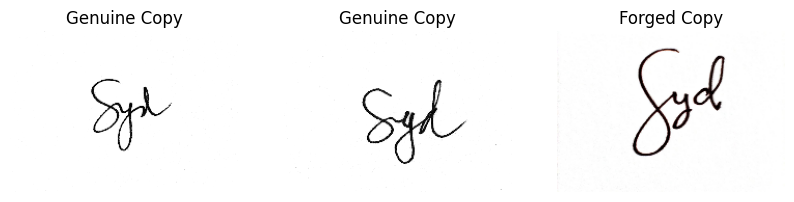

In [47]:
visualize_sample_signature()

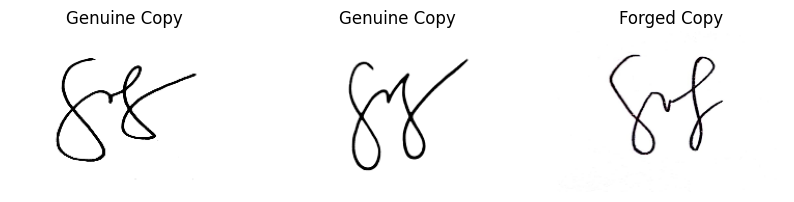

In [48]:
visualize_sample_signature()

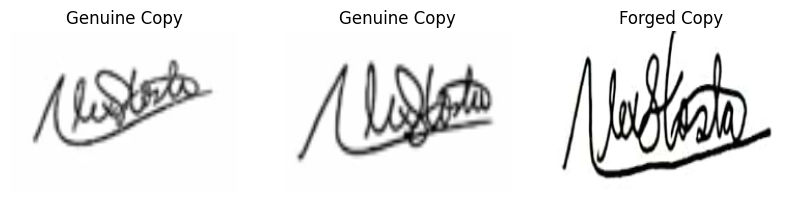

In [49]:
visualize_sample_signature()

In [50]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [51]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [52]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [53]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [54]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06,axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), data_format='channels_last'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu
    
    return seq

In [55]:
input_shape=(img_h, img_w, 1)

In [56]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [57]:
batch_sz = 128
num_train_samples = 276*16 + 300*16
num_val_samples = num_test_samples = 276*4 + 300*4
num_train_samples, num_val_samples, num_test_samples

(9216, 2304, 2304)

In [58]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [59]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.000001, verbose=1),
    ModelCheckpoint("snnmodel2.h5", verbose=1, save_weights_only=False, save_best_only=True, mode='auto',save_freq="epoch")
]

In [60]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 25,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/25
72/72 [==============================] - ETA: 0s - loss: 3.9385
Epoch 1: val_loss improved from inf to 1.40400, saving model to snnmodel2.h5
72/72 [==============================] - 557s 8s/step - loss: 3.9385 - val_loss: 1.4040 - lr: 1.0000e-04
Epoch 2/25


c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - ETA: 0s - loss: 1.1653
Epoch 2: val_loss improved from 1.40400 to 1.36678, saving model to snnmodel2.h5
72/72 [==============================] - 651s 9s/step - loss: 1.1653 - val_loss: 1.3668 - lr: 1.0000e-04
Epoch 3/25
72/72 [==============================] - ETA: 0s - loss: 1.0954
Epoch 3: val_loss improved from 1.36678 to 1.28083, saving model to snnmodel2.h5
72/72 [==============================] - 695s 10s/step - loss: 1.0954 - val_loss: 1.2808 - lr: 1.0000e-04
Epoch 4/25
72/72 [==============================] - ETA: 0s - loss: 1.0141
Epoch 4: val_loss improved from 1.28083 to 1.21831, saving model to snnmodel2.h5
72/72 [==============================] - 621s 9s/step - loss: 1.0141 - val_loss: 1.2183 - lr: 1.0000e-04
Epoch 5/25
20/72 [=======>......................] - ETA: 6:24 - loss: 0.9709

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [ ]:
#model.load_weights('C:/Users/Sophia/Weights/signatureverification_snn-003.h5')
#from tensorflow.keras.models import load_model

#model = load_model("snnmodel.h5")
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  6461084   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

In [ ]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

1/1 [==============================] - 0s 52ms/step


In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.5430055000723694, 0.010001008622348309)

In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

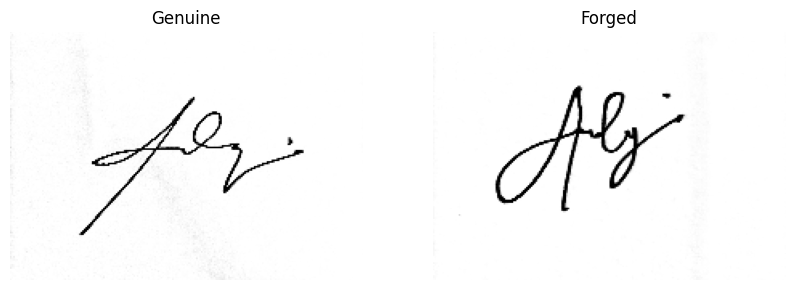

1/1 [==============================] - 0s 53ms/step
Difference Score =  0.012111275
Its a Forged Signature


In [ ]:
predict_score()

### Note: The first image is always Genuine. Score prediction and classification is done for the second image

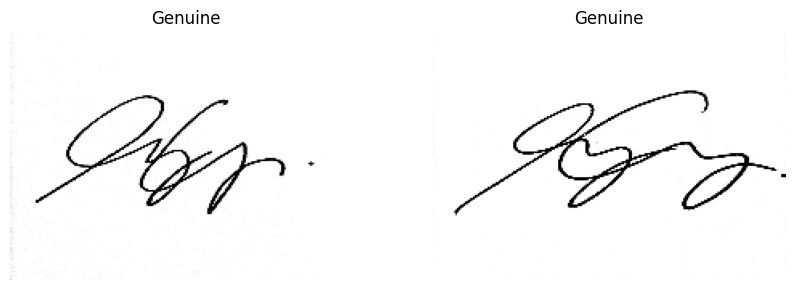

1/1 [==============================] - 0s 58ms/step
Difference Score =  0.004199163
Its a Genuine Signature


In [ ]:
predict_score()

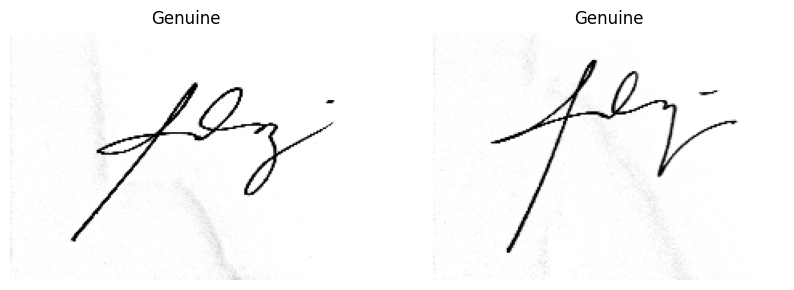

1/1 [==============================] - 0s 70ms/step
Difference Score =  0.003956331
Its a Genuine Signature


In [ ]:
predict_score()

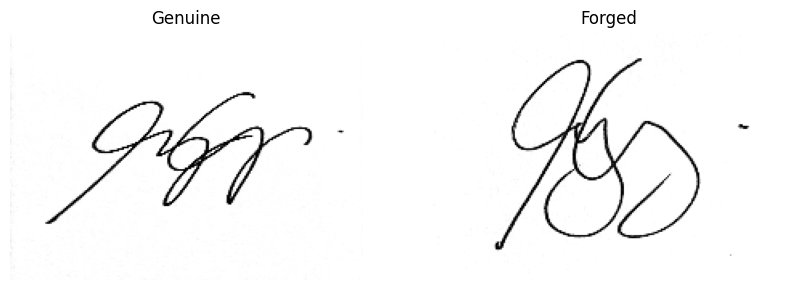

1/1 [==============================] - 0s 60ms/step
Difference Score =  0.009382536
Its a Genuine Signature


In [ ]:
predict_score()

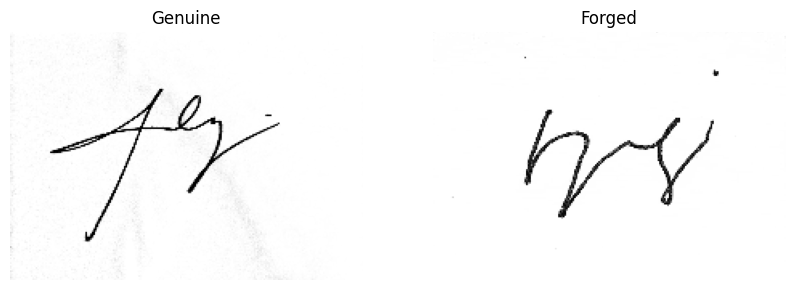

1/1 [==============================] - 0s 60ms/step
Difference Score =  0.0020689536
Its a Genuine Signature


In [ ]:
predict_score()

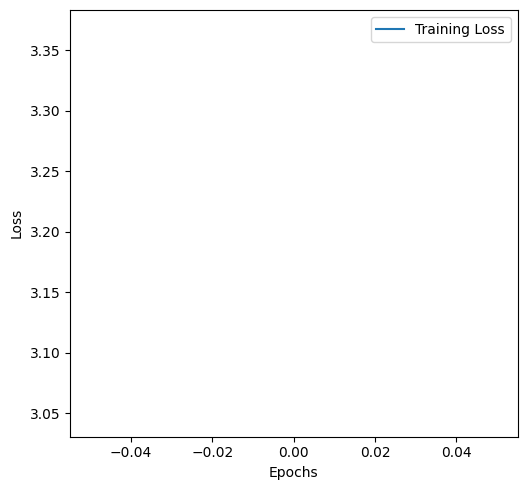

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save("snnmode12.h5")

In [ ]:
import h5py

with h5py.File("snnmodel.h5", "r") as file:
    # Access and examine the file contents
    print(file.keys())  # Print the keys of the file groups and datasets


<KeysViewHDF5 ['model_weights', 'optimizer_weights']>


In [ ]:
def predict_score(img1, img2):
    '''Predict distance score and classify test images as Genuine or Forged'''
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("It's a Forged Signature")
    else:
        print("It's a Genuine Signature")


Please select two images for testing:


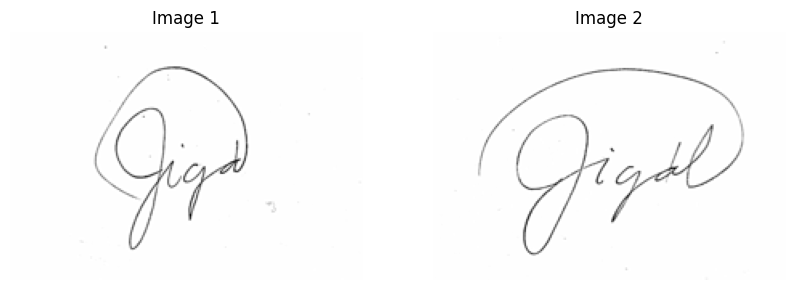

1/1 [==============================] - 0s 156ms/step
Difference Score = 2.8230522
It's a Forged Signature


In [ ]:
from PIL import Image

"""""
IMG_SIZE = (128, 128)  # Desired image size
MEAN = 0.5  # Mean value for normalization
STD = 0.5  # Standard deviation value for normalization

def preprocess_signature(image):
    # Resize the image
    image = cv2.resize(image, IMG_SIZE)

    # Convert the image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Normalize the image
    image = (image / 255.0 - MEAN) / STD

    # Convert the image to PIL format
    image = Image.fromarray(image)

    # Convert the image to tensor
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)

    return image
"""


def select_images():
    '''Prompt the user to select images for testing'''
    print("Please select two images for testing:")
    image_paths = []
    for i in range(2):
        while True:
            image_path = input(f"Enter the path to image {i+1}: ")
            if os.path.exists(image_path):
                image_paths.append(image_path)
                break
            else:
                print("Invalid image path. Please try again.")
    images = []
    for image_path in image_paths:
        image = Image.open(image_path).convert("L")
        image_resized = image.resize((220, 155))
        image_array = np.array(image_resized)
        image_reshaped = np.expand_dims(image_array, axis=2)
        images.append(image_reshaped)
    
    img1, img2 = images[0], images[1]
    return img1, img2


def predict_score(img1, img2, threshold=1.5):
    '''Predict distance score and classify test images as Genuine or Forged'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Image 1')
    ax2.set_title('Image 2')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)
    
    result = model.predict([img1, img2])
    diff = result[0][0]
    #threshold = 0.55
    print("Difference Score =", diff)
    if diff > threshold:
        print("It's a Forged Signature")
    else:
        print("It's a Genuine Signature")

# Prompt the user to select images
selected_img1, selected_img2 = select_images()

# Call the predict_score function with the selected images
predict_score(selected_img1, selected_img2, threshold=1.5)